## Prerequisites

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import originalcsv file

In [2]:
df = pd.read_csv('mental-heath-in-tech-2016_20161114.csv', encoding='utf-8')

First we print a preview of our dataframe to get a broad overview of the data

In [3]:
print(df.head())

   Are you self-employed?  \
0                       0   
1                       0   
2                       0   
3                       1   
4                       0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                                NaN           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                1.0         
1                                                1.0         
2                                                1.0         
3                                                NaN         
4                                                0.0         

   Is your primary role within your company related to tech/IT?  \


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

## Data Visualization
I want to start to explore the data. Therfore some standard visualizations should help to get an overview of distributions and correlations.

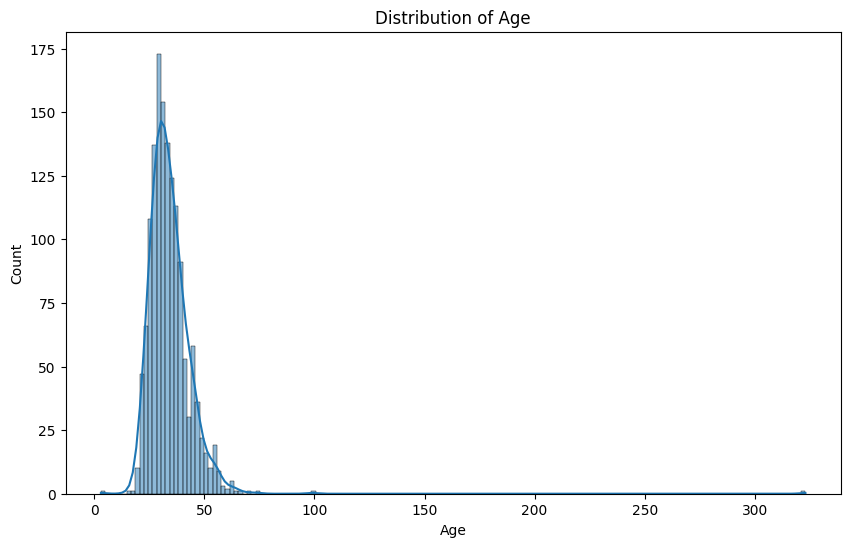

In [5]:
# Distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(df['What is your age?'], kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

I see that the age is normally distributed, which is a good sign that there is enough data to be representative. There are some outliers and unplausible values. These values need to be cleaned later.

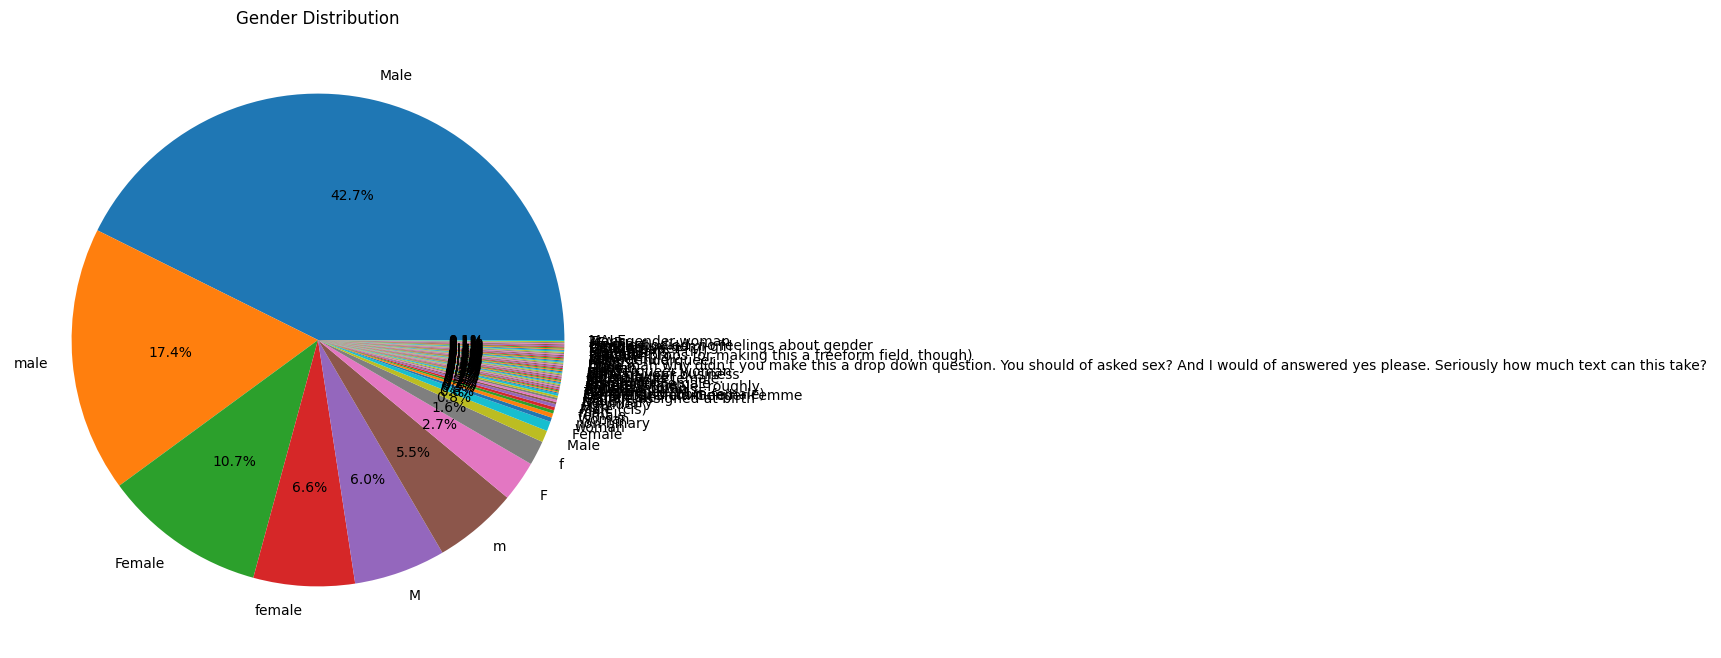

In [6]:
# Gender breakdown
gender_counts = df['What is your gender?'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

There are a lot of categories that mean the same, but in different variations. This should also be addressed in the data cleaning.

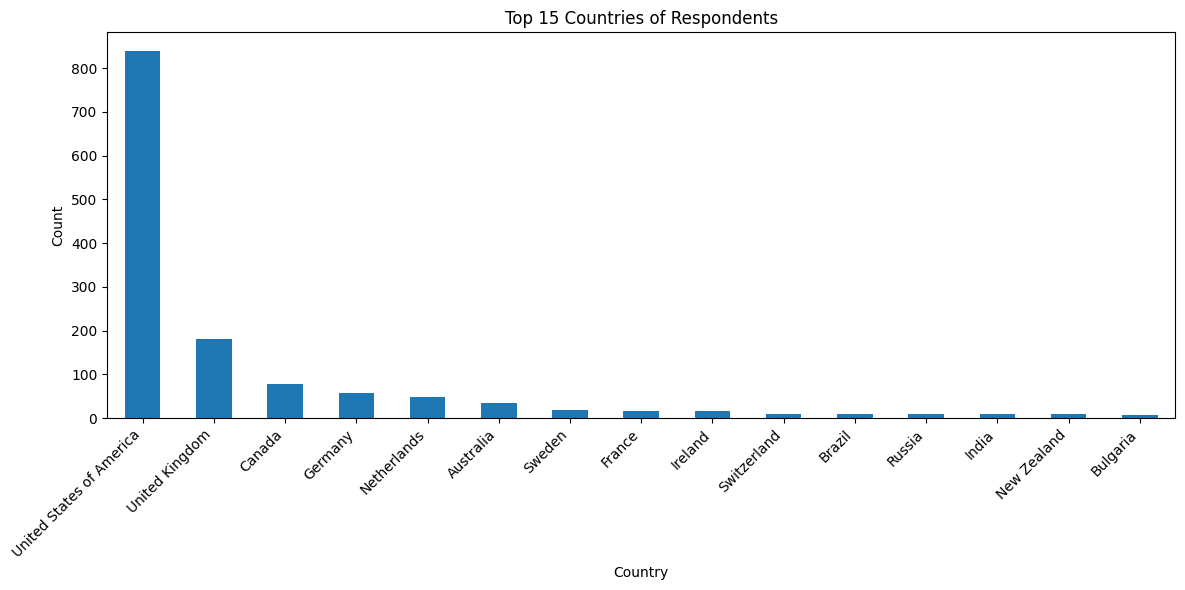

In [7]:
# Geographic distribution
country_counts = df['What country do you live in?'].value_counts().head(15)
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar')
plt.title('Top 15 Countries of Respondents')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The graph clearly shows that the USA has by far the largest number of respondents, providing a much more robust and statistically significant sample size compared to other countries.


Reasons to truncate the data for USA:
- Data Homogeneity: It can be beneficial that focus lies on respondents from USA for different reasons: Focusing on a single country eliminates potential confounding variables related to different cultural, legal, and healthcare systems across countries, allowing for more controlled and meaningful comparisons within the dataset.
- Relevance to Tech Industry: The USA is home to major tech hubs like Silicon Valley, Seattle, and New York, making the data particularly relevant to understanding mental health issues in the global tech industry's epicenter.
- Statistical Power: With such a large sample from the USA, you're more likely to detect subtle patterns or effects that might not be visible in smaller subsets from other countries.
- Reduced Noise: Including data from countries with very few respondents could introduce noise and potentially skew results due to small, non-representative samples from those locations.

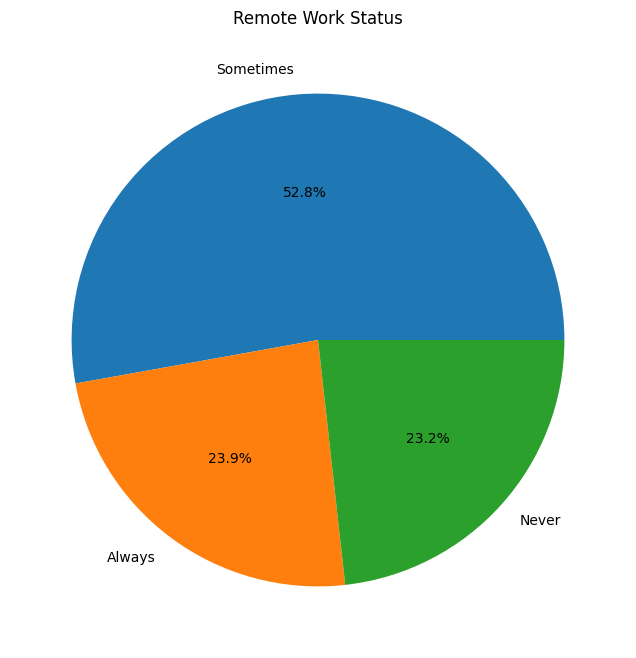

In [8]:
# Remote work status
remote_counts = df['Do you work remotely?'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(remote_counts.values, labels=remote_counts.index, autopct='%1.1f%%')
plt.title('Remote Work Status')
plt.show()

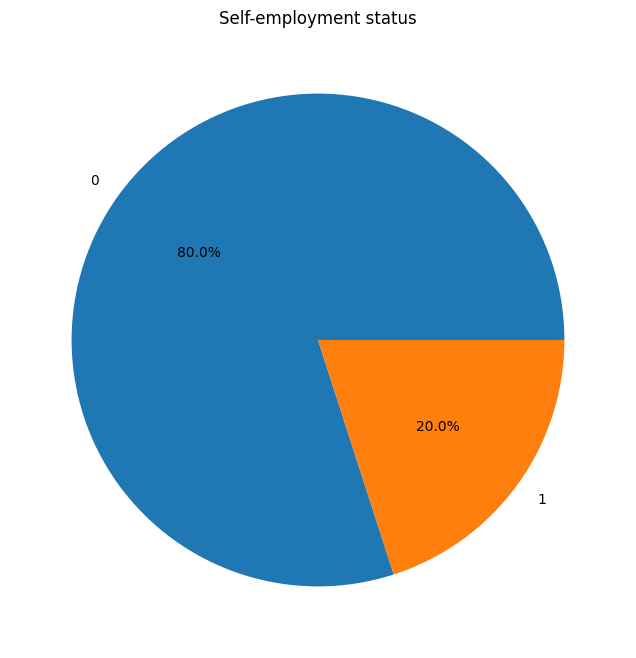

In [9]:
# Self-employment status
selfemp_counts = df['Are you self-employed?'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(selfemp_counts.values, labels=selfemp_counts.index, autopct='%1.1f%%')
plt.title('Self-employment status')
plt.show()

Exactly 80% of the respondents are employees. It needs to be considered if self-employed workers are relevant for company-wide measures to improve mental health.

Reasons:
- Different work environments: Self-employed individuals often work in vastly different environments compared to company employees. They may work from home, co-working spaces, or have more flexible schedules, which can affect mental health differently than a traditional office setting.
Lack of company policies: Self-employed workers are not subject to company-wide mental health policies, benefits, or initiatives. This makes it difficult to assess the impact of such measures on mental health.
- Absence of workplace dynamics: The analysis of mental health in a company setting often involves examining team dynamics, management practices, and workplace culture. These factors are largely absent or significantly different for self-employed individuals.
- Benefits and support systems: Company employees often have access to employer-provided health insurance, Employee Assistance Programs (EAPs), and other support systems that self-employed individuals typically do not have.
- Performance evaluation: The stress and mental health impacts associated with performance reviews, KPIs, and other evaluation metrics common in companies are not typically experienced by self-employed workers in the same way.
- Company-wide initiatives: If the goal is to develop company-wide strategies to improve mental health, including self-employed workers in the analysis could skew results and lead to recommendations that are not applicable to the target population (company employees).

Given these factors, focusing the analysis solely on company employees would likely yield more relevant and actionable insights for improving mental health in corporate IT environments.

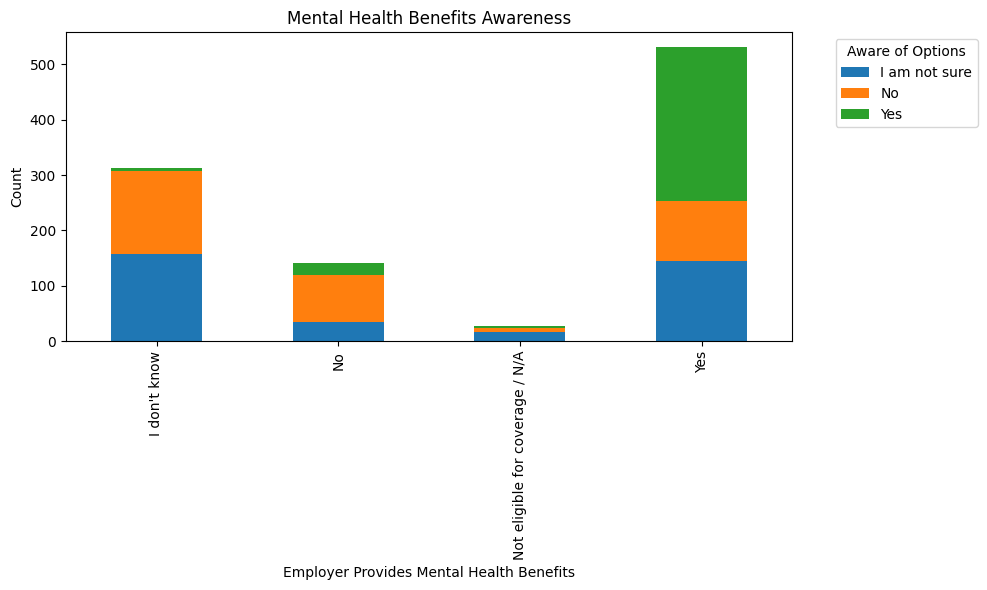

In [10]:
# Mental health benefits awareness
benefits_aware = pd.crosstab(df['Does your employer provide mental health benefits as part of healthcare coverage?'], 
                             df['Do you know the options for mental health care available under your employer-provided coverage?'])
benefits_aware.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Mental Health Benefits Awareness')
plt.xlabel('Employer Provides Mental Health Benefits')
plt.ylabel('Count')
plt.legend(title='Aware of Options', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Insights:
- Availability of Mental Health Benefits: A significant number of employers provide mental health benefits as part of healthcare coverage (the "Yes" column). However, there's also a substantial portion who don't provide these benefits or where employees are unsure (the "No" and "I don't know" columns).
- Awareness Gap: Even among employees whose employers provide mental health benefits (the "Yes" column), a large portion are either unaware of the options available or unsure about them (blue and orange sections). This suggests a significant communication gap between employers and employees regarding mental health benefits.
- Opportunity for Improvement: There's a clear opportunity for employers to improve both the provision of mental health benefits and the communication about these benefits to employees.

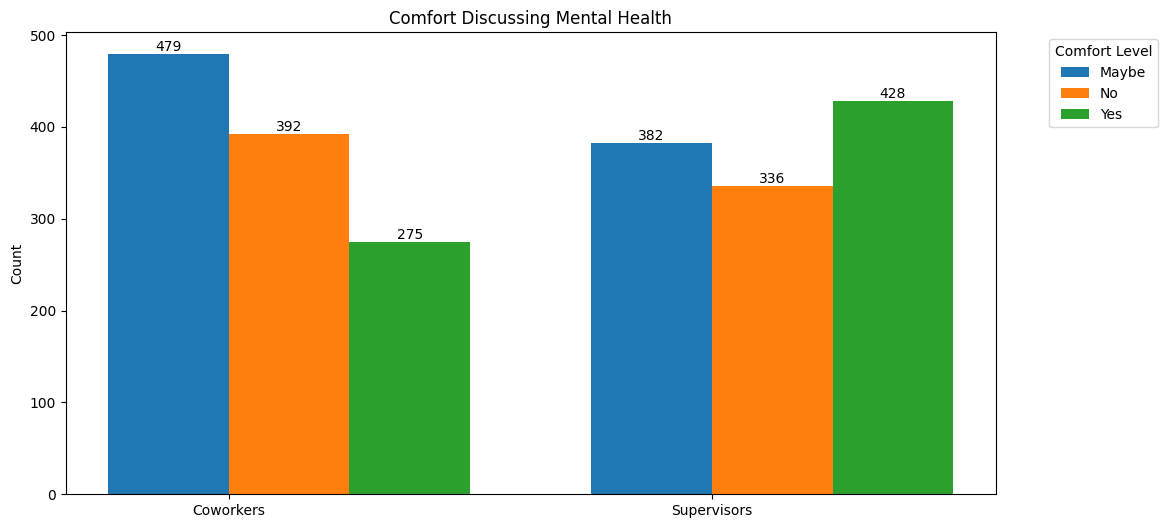

In [32]:
# Comfort discussing mental health
comfort_data = df[['Would you feel comfortable discussing a mental health disorder with your coworkers?',
                   'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?']]
comfort_data = comfort_data.melt(var_name='Discuss With', value_name='Comfort Level')
comfort_data['Discuss With'] = comfort_data['Discuss With'].map({
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'Coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'Supervisors'
})

# Count the data
count_data = comfort_data.groupby(['Discuss With', 'Comfort Level']).size().unstack(fill_value=0)

# Set up the plot
plt.figure(figsize=(12, 6))
ax = plt.subplot()

# Plot the bars
index = range(len(count_data.index))
for i, comfort_level in enumerate(count_data.columns):
    bars = ax.bar([x + i*bar_width for x in index], count_data[comfort_level], 
                  bar_width, label=comfort_level)
    
    # Add labels on the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}',
                ha='center', va='bottom')

# Customize the plot
plt.title('Comfort Discussing Mental Health')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks([x + bar_width/2 for x in index], count_data.index)
plt.legend(title='Comfort Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Key Observations

1. **Coworker vs Supervisor Comfort**
   - More respondents comfortable discussing with supervisors (428) than coworkers (275)
   - Fewer respondents uncomfortable discussing with supervisors (336) than coworkers (392)

2. **Uncertainty Prevalence**
   - "Maybe" responses highest for both categories (479 for coworkers, 382 for supervisors)
   - Indicates significant uncertainty or context-dependence in comfort levels

3. **Coworker Discussions**
   - Lowest comfort level (275 "Yes" responses)
   - Highest discomfort level (392 "No" responses)

4. **Supervisor Discussions**
   - Highest comfort level (428 "Yes" responses)
   - More balanced distribution among comfort levels

5. **Overall Hesitancy**
   - Combined "No" and "Maybe" responses outnumber "Yes" for both categories

## Implications

- Workplace culture may favor hierarchical communication about mental health
- Significant opportunity to improve peer-to-peer mental health discussions
- Need for clear guidelines on discussing mental health in workplace settings
- Potential benefit in mental health awareness training, especially for peer interactions
- Supervisors might be seen as more capable of addressing or understanding mental health concerns
- High "Maybe" responses suggest situational factors influence comfort levels
- Interventions needed to reduce uncertainty and increase overall comfort in mental health discussions
- Company policies might need review to encourage open dialogue about mental health

In [16]:
# Calculate the number and percentage of missing values
missing_values = df.isnull().sum()
missing_percentages = 100 * df.isnull().sum() / len(df)

# Combine into a table
missing_table = pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing Values', 'Percentage Missing'])

# Sort by the number of missing values in descending order
missing_table = missing_table.sort_values('Missing Values', ascending=False)

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display the table
print(missing_table)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

                                                                                                                                                                                  Missing Values  \
If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?                                                                1289   
If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?                                                        1229   
Is your primary role within your company related to tech/IT?                                                                                                                                1170   
Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?                                                                       1146   
If you have been dia

There are a few columns that we will need to drop because too many values are missing. When the data is cleaned the issue of missing values needs to be addressed.

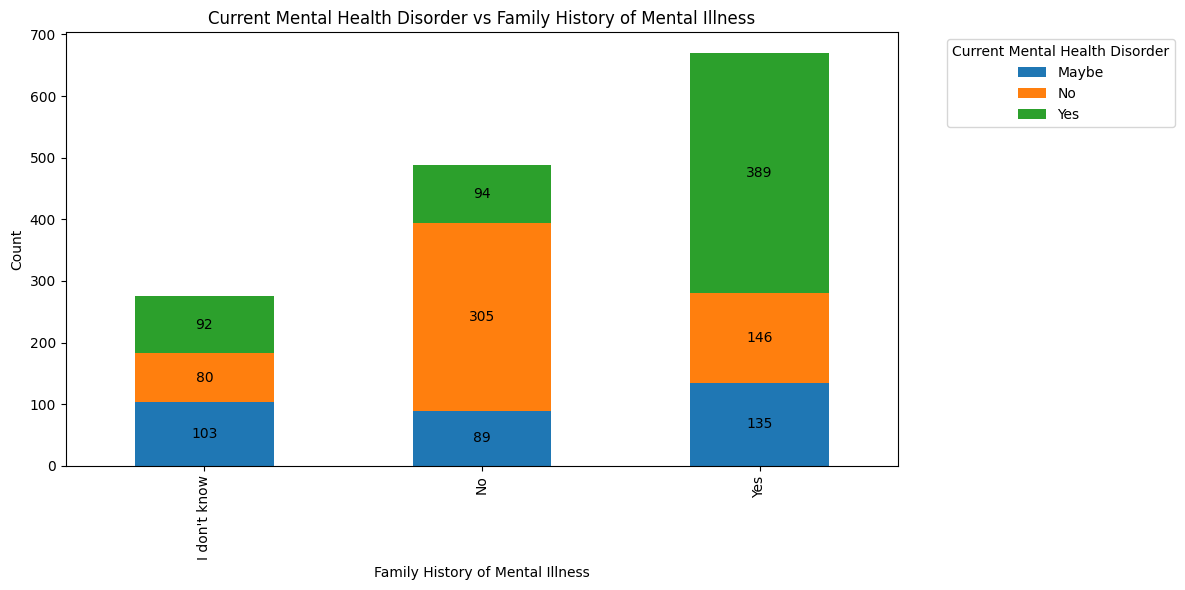

In [17]:
# Create a cross-tabulation of the two variables
cross_tab = pd.crosstab(df['Do you have a family history of mental illness?'], 
                        df['Do you currently have a mental health disorder?'])

# Create a stacked bar chart
ax = cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Current Mental Health Disorder vs Family History of Mental Illness')
plt.xlabel('Family History of Mental Illness')
plt.ylabel('Count')
plt.legend(title='Current Mental Health Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

plt.show()

## Key Observations

1. **Family History Impact**
   - 58% of individuals with family history report current mental health disorders
   - Suggests potential genetic or environmental correlation

2. **No Family History**
   - 62.5% without family history report no current mental health disorder
   - 19% still report current disorders, indicating other factors at play

3. **Uncertainty**
   - 275 respondents unsure about family history
   - Even distribution among current disorder status in this group

4. **Prevalence of Mental Health Disorders**
   - Significant presence across all family history categories

5. **Awareness and Diagnosis**
   - "Maybe" responses suggest potential undiagnosed cases or uncertainty

6. **Risk Assessment**
   - Family history appears to be a risk factor, but not deterministic

7. **Need for Mental Health Education**
   - High "I don't know" responses indicate need for better awareness and communication

8. **Complex Relationship**
   - Distribution suggests non-straightforward connection between family history and current mental health

## Implications

- Family history is important but part of a complex picture
- Underscores need for mental health awareness and education
- Highlights importance of accessible mental health resources for all
- Suggests value in considering family history for risk assessments and prevention strategies

## Data Preprocessing
we need to clean some columns before we continue. this includes renaming all columns for easier handling, such that we dont need to use the complete questions. standardizing age column, mental health condition column and convert all categorical columns to binary numerical columns.

In [ ]:
# Rename all columns so they are handled more easily
# Define a dictionary to map old column names to new ones
column_map = {
    'Are you self-employed?': 'self_employed',
    'How many employees does your company or organization have?': 'company_size',
    'Is your employer primarily a tech company/organization?': 'tech_company',
    'Is your primary role within your company related to tech/IT?': 'tech_role',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'emp_mh_benefits',
    'Do you know the options for mental health care available under your employer-provided coverage?': 'know_mh_options',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'emp_discussed_mh',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'mh_resources',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'anonymity_protected',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'leave_difficulty',
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?': 'neg_consequences_mental_discuss',
    'Do you think that discussing a physical health issue with your employer would have negative consequences?': 'neg_consequences_physical_discuss',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'comfortable_discuss_coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'comfortable_discuss_supervisors',
    'Do you feel that your employer takes mental health as seriously as physical health?': 'emp_mh_seriously',
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': 'observed_neg_consequences',
    'Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues?': 'mh_coverage',
    'Do you know local or online resources to seek help for a mental health disorder?': 'know_local_online_resources',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?': 'reveal_clients',
    'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?': 'neg_impact_reveal_clients',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?': 'reveal_coworkers',
    'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?': 'neg_impact_reveal_coworkers',
    'Do you believe your productivity is ever affected by a mental health issue?': 'mh_affects_productivity',
    'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?': 'productivity_affected_percent',
    'Do you have previous employers?': 'previous_emp',
    'Have your previous employers provided mental health benefits?': 'previous_emp_mh_benefits',
    'Were you aware of the options for mental health care provided by your previous employers?': 'aware_prev_mh_options',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?': 'prev_employers_discussed_mh',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?': 'prev_mh_resources',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?': 'prev_anonymity_protected',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?': 'prev_neg_consequences_discuss',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?': 'prev_neg_consequences_physical',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?': 'prev_comfortable_discuss_coworkers',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?': 'prev_comfortable_discuss_supervisors',
    'Did you feel that your previous employers took mental health as seriously as physical health?': 'prev_emp_mh_seriously',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?': 'prev_observed_neg_consequences',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?': 'mention_discuss_physical_interview',
    'Why or why not?': 'mention_discuss_physical_interview_reason',
    'Would you bring up a mental health issue with a potential employer in an interview?': 'mention_discuss_mh_interview',
    'Why or why not?.1': 'mention_discuss_mh_interview_reason',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?': 'mh_hurt_career',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': 'coworkers_view_negatively',
    'How willing would you be to share with friends and family that you have a mental illness?': 'willing_share_friends_family',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': 'experienced_unsupportive_response',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?': 'others_experience_affect_you',
    'Do you have a family history of mental illness?': 'family_history',
    'Have you had a mental health disorder in the past?': 'past_mh_disorder',
    'Do you currently have a mental health disorder?': 'current_mh_disorder',
    'If yes, what condition(s) have you been diagnosed with?': 'diagnosed_conditions',
    'If maybe, what condition(s) do you believe you have?': 'believed_conditions',
    'Have you been diagnosed with a mental health condition by a medical professional?': 'professionally_diagnosed',
    'If so, what condition(s) were you diagnosed with?': 'professional_diagnoses',
    'Have you ever sought treatment for a mental health issue from a mental health professional?': 'sought_treatment',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': 'work_interference_treated',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': 'work_interference_untreated',
    'What is your age?': 'age',
    'What is your gender?': 'gender',
    'What country do you live in?': 'country',
    'What US state or territory do you live in?': 'state',
    'What country do you work in?': 'work_country',
    'What US state or territory do you work in?': 'work_state',
    'Which of the following best describes your work position?': 'position',
    'Do you work remotely?': 'remote_work'
}

# Rename the columns
df.rename(columns=column_map, inplace=True)

In [ ]:
# Clean up the gender column
male_values = [
    'male', 'Male ', 'M', 'm', 'man', 'Cis male',
    'Male.', 'Male (cis)', 'Man', 'Sex is male',
    'cis male', 'Malr', 'Dude', "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
    'mail', 'M|', 'male ', 'Cis Male', 'Male (trans, FtM)',
    'cisdude', 'cis man', 'MALE'
]

female_values = [
    'female', 'I identify as female.', 'female ',
    'Female assigned at birth ', 'F', 'Woman', 'fm', 'f',
    'Cis female', 'Transitioned, M2F', 'Female or Multi-Gender Femme',
    'Female ', 'woman', 'female/woman', 'Cisgender Female', 
    'mtf', 'fem', 'Female (props for making this a freeform field, though)',
    ' Female', 'Cis-woman', 'AFAB', 'Transgender woman',
    'Cis female '
]

other_values = [
    'Bigender', 'non-binary,', 'Genderfluid (born female)',
    'Other/Transfeminine', 'Androgynous', 'male 9:1 female, roughly',
    'nb masculine', 'genderqueer', 'Human', 'Genderfluid',
    'Enby', 'genderqueer woman', 'Queer', 'Agender', 'Fluid',
    'Genderflux demi-girl', 'female-bodied; no feelings about gender',
    'non-binary', 'Male/genderqueer', 'Nonbinary', 'Other', 'none of your business',
    'Unicorn', 'human', 'Genderqueer'
]

df['gender'] = df['gender'].replace(male_values, 'Male')
df['gender'] = df['gender'].replace(female_values, 'Female')
df['gender'] = df['gender'].replace(other_values, 'Others')

# replace missing values for three rows for gender with the mode Male
df['gender'] = df['gender'].replace(np.nan, 'Male')

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# Histogram plot
sns.histplot(data=df, x='age', kde=True, color='skyblue', edgecolor='black', ax=ax1)
ax1.set_title('Age Distribution - Histogram', fontsize=16)
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Boxplot with marked outliers
sns.boxplot(data=df, x='age', color='lightgreen', ax=ax2, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8, 'markeredgecolor': 'black'})
ax2.set_title('Age Distribution - Boxplot', fontsize=16)
ax2.set_xlabel('Age', fontsize=12)

# Add a text annotation explaining the outliers
ax2.text(0.95, 0.95, 'Red dots: Outliers', transform=ax2.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Find relevant outliers to replace them
# Get the top 5 max values
top_10 = df['age'].nlargest(10)

# Get the bottom 5 min values
bottom_10 = df['age'].nsmallest(10)

print("Top 10 maximum ages:")
print(top_10)

print("\nBottom 10 minimum ages:")
print(bottom_10)

In [ ]:
# Create a copy of the DataFrame to avoid modifying the original
df_cleaned = df.copy()

# List of outlier values
outliers = [323, 99, 3, 15, 17]

# Calculate the median of non-outlier ages
median_age = df_cleaned[~df_cleaned['age'].isin(outliers)]['age'].median()

# Replace outliers and missing values with the calculated median
df_cleaned['age'] = df_cleaned['age'].replace(outliers, median_age)
df_cleaned['age'] = df_cleaned['age'].fillna(median_age)

# Create side by side boxplots of the two dataframes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Boxplot for original data
sns.boxplot(data=df, y='age', color='skyblue', ax=ax1, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8, 'markeredgecolor': 'black'})
ax1.set_title('Original Age Distribution', fontsize=16)
ax1.set_ylabel('Age', fontsize=12)
ax1.set_xlabel('Original Data', fontsize=12)

# Add a text annotation explaining the outliers for original data
ax1.text(0.95, 0.95, 'Red dots: Outliers of the 75 percentile', transform=ax1.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Boxplot for cleaned data
sns.boxplot(data=df_cleaned, y='age', color='lightgreen', ax=ax2, 
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8, 'markeredgecolor': 'black'})
ax2.set_title('Cleaned Age Distribution', fontsize=16)
ax2.set_ylabel('Age', fontsize=12)
ax2.set_xlabel('Cleaned Data', fontsize=12)

# Add a text annotation explaining the outliers for cleaned data
ax2.text(0.95, 0.95, 'Red dots: Outliers', transform=ax2.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Print summary statistics to verify the changes
print("\nOriginal age column summary:")
print(df['age'].describe())
print("\nCleaned age column summary:")
print(df_cleaned['age'].describe())

# Replace the original df with the new one for further processing
df = df_cleaned


In [ ]:
# List of all unique conditions
conditions = [
    'Anxiety Disorder',
    'Mood Disorder',
    'Attention Deficit Hyperactivity Disorder',
    'Post-traumatic Stress Disorder',
    'Stress Response Syndromes',
    'Personality Disorder',
    'Obsessive-Compulsive Disorder',
    'Eating Disorder',
    'Substance Use Disorder',
    'Addictive Disorder',
    'Psychotic Disorder',
    'Dissociative Disorder',
    'Autism',
    'Asperger Syndrome',
    'Gender Identity Disorder',
    'Intimate Disorder',
    'Traumatic Brain Injury',
    'Seasonal Affective Disorder',
    'Burn out',
    'Depersonalization Disorder',
    'Tinnitus',
    'Suicidal Ideation'
]

# Function to check if a condition is present
# For PDD-NOS we also use Autism
def has_condition(row, condition):
    if pd.isna(row):
        return 0
    if condition == 'Autism':
        return 1 if any(c in row for c in ['Autism', 'PDD-NOS']) else 0
    return 1 if condition in row else 0

# Create binary columns for each condition, that has been professionally diagnosed
for condition in conditions:
    df[f'Has_{condition.replace(" ", "_")}'] = df['diagnosed_conditions'].apply(lambda x: has_condition(x, condition))
    
# Get list of columns to potentially drop
columns_to_check = [col for col in df.columns if col.startswith('Has_')]

# Find columns with all zeros
columns_to_drop = [col for col in columns_to_check if df[col].max() == 0]

# Drop the columns
df = df.drop(columns=columns_to_drop)

#### drop columns and rows that we most likely wont need in our analysis

mental health conditions probably depend highly on external factos between countries. as we want to focus on the employer effects it does make sense to only look at one country to have comparable individuals

In [ ]:
# drop all rows that are not USA
# df=df[df['work_country']=='United States of America']
# df=df.reset_index(drop=True)

# drop columns that are not relevant for our analysis
df=df.drop(columns=['country', 'state', 'previous_emp', 'previous_emp_mh_benefits', 'aware_prev_mh_options','prev_employers_discussed_mh', 'prev_mh_resources', 'prev_anonymity_protected', 'prev_neg_consequences_discuss', 'prev_neg_consequences_physical', 'prev_comfortable_discuss_coworkers', 'prev_comfortable_discuss_supervisors', 'prev_emp_mh_seriously', 'prev_observed_neg_consequences', 'willing_share_friends_family', 'reveal_clients', 'neg_impact_reveal_clients', 'reveal_coworkers', 'neg_impact_reveal_coworkers'])

# keep only the current mental health condition (not the ones the participants "maybe" have and not the ones that were diagnosed in the past)
df=df.drop(columns=['believed_conditions','professionally_diagnosed','professional_diagnoses','diagnosed_conditions','past_mh_disorder', 'current_mh_disorder'])

# drop free text columns
df=df.drop(columns=['mention_discuss_physical_interview_reason','mention_discuss_mh_interview_reason'])

# drop all rows where self_employed is 1, because from HR perspective only "normal" employees are relevant
df=df[df['self_employed']==0]
df=df.reset_index(drop=True)

# drop the columns that only have values for self-employed employees
df=df.drop(columns=['mh_coverage','know_local_online_resources','mh_affects_productivity', 'productivity_affected_percent'])

# drop work_state because there is no value for other countries than USA and we can not fill in missing values
df=df.drop(columns=['work_state'])

In [ ]:
# Calculate percentage of missing values
missing_percentages = df.isnull().mean() * 100

# Sort the percentages in descending order and filter out columns with no missing values
missing_percentages_sorted = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

print("\nPercentage of missing values (sorted in descending order):")
for col, pct in missing_percentages_sorted.items():
    print(f"{col}: {pct:.2f}%")

In [ ]:
# drop columns with more than 50% missing values
df = df.drop(columns=['tech_role','others_experience_affect_you'])

In [ ]:
# Define company size categories
company_sizes = [
    '1-5',
    '6-25',
    '26-100',
    '100-500',
    '500-1000',
    'More than 1000'
]

# Function to check company size
def company_size_category(size, category):
    if pd.isna(size):
        return 0
    if category == 'More than 1000':
        return 1 if size == category or size == '>1000' else 0
    return 1 if size == category else 0

# Create binary columns for each company size
for size in company_sizes:
    column_name = f'company_size_{size.replace(" ", "_")}'
    df[column_name] = df['company_size'].apply(lambda x: company_size_category(x, size))
    
# Drop company_size column
df = df.drop(columns=['company_size'])

In [ ]:
# Create binary columns for emp_mh_benefits column
# Define emp_mh_benefits categories
emp_mh_benefits_categories = [
    "Yes",
    "I don't know",
    "No",
    "Not eligible for coverage / N/A"
]

# Function to check emp_mh_benefits category
def emp_mh_benefits_category(value, category):
    if pd.isna(value):
        return 0
    return 1 if value == category else 0

# Function to create a valid column name
def create_column_name(category):
    return "emp_mh_benefits_" + category.replace(' ', '_').replace('/', '').replace("'", "")

# Create binary columns for each emp_mh_benefits category
for category in emp_mh_benefits_categories:
    column_name = create_column_name(category)
    df[column_name] = df['emp_mh_benefits'].apply(lambda x: emp_mh_benefits_category(x, category))

# Rename one column
df=df.rename(columns={'emp_mh_benefits_Not_eligible_for_coverage__NA': 'emp_mh_benefits_Not_eligible_for_coverage'})

# Drop the original emp_mh_benefits column
df = df.drop(columns=['emp_mh_benefits'])

#### convert know_mh_benefits to binary column and fill missing values with most frequent value

In [ ]:
# Define know_mh_options categories
know_mh_options_categories = [
    "Yes",
    "I am not sure",
    "No"
]

# Create SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values
df['know_mh_options'] = imputer.fit_transform(df[['know_mh_options']]).ravel()

# Function to check know_mh_options category
def know_mh_options_category(value, category):
    return 1 if value == category else 0

# Create binary columns for each know_mh_options category
for category in know_mh_options_categories:
    column_name = f"know_mh_options_{category.replace(' ', '_')}"
    df[column_name] = df['know_mh_options'].apply(lambda x: know_mh_options_category(x, category))

# Drop the original know_mh_options column
df = df.drop(columns=['know_mh_options'])

#### create binary column for all other categorical columns that are easy to handle

In [ ]:
def safe_column_name(name):
    return re.sub(r'\W+', '_', str(name))

def create_binary_columns(df, column_name):
    # Get unique values
    unique_values = df[column_name].unique()
    
    # Create binary columns
    new_columns = []
    for value in unique_values:
        new_column_name = f"{column_name}_{safe_column_name(value)}"
        df[new_column_name] = (df[column_name] == value).astype(int)
        new_columns.append(new_column_name)
    
    # Drop the original column
    df = df.drop(columns=[column_name])
    
    return df

# List of columns to convert
columns_to_convert = [
    'emp_discussed_mh', 'anonymity_protected', 'mh_resources', 'leave_difficulty',
    'neg_consequences_mental_discuss', 'neg_consequences_physical_discuss',
    'comfortable_discuss_coworkers', 'comfortable_discuss_supervisors',
    'emp_mh_seriously', 'observed_neg_consequences', 'mention_discuss_physical_interview',
    'mention_discuss_mh_interview', 'mh_hurt_career', 'coworkers_view_negatively',
    'family_history', 'work_interference_treated', 'work_interference_untreated',
    'gender', 'remote_work'
]

# Apply the conversion to each column
for column in columns_to_convert:
    df = create_binary_columns(df, column)

#### simplifiy position columns to IT and Management

In [ ]:
def categorize_position(position):
    roles = position.split('|')
    
    it_roles = ['Back-end Developer', 'Front-end Developer', 'DevOps/SysAdmin', 'Dev Evangelist/Advocate']
    management_roles = ['Executive Leadership', 'Supervisor/Team Lead']
    
    is_it_role = 1 if any(role in it_roles for role in roles) else 0
    is_management = 1 if any(role in management_roles for role in roles) else 0
    
    return is_it_role, is_management

# Assuming your dataframe is named 'df' and the column is named 'position'
df['Is_IT_Role'], df['Is_Management'] = zip(*df['position'].apply(categorize_position))

# Display the results
print(df[['position', 'Is_IT_Role', 'Is_Management']].head(10))

# Drop the original 'position' column
df = df.drop(columns=['position'])

#### convert expoerience_unsupportive_response column

In [ ]:
# Define experienced_unsupportive_response categories
experienced_unsupportive_response_categories = [
    "No",
    "Maybe/Not sure",
    "Yes"
]

# Create SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values
df['experienced_unsupportive_response'] = imputer.fit_transform(df[['experienced_unsupportive_response']]).ravel()

# Combine "Yes" categories
df['experienced_unsupportive_response'] = df['experienced_unsupportive_response'].replace({
    'Yes, I observed': 'Yes',
    'Yes, I experienced': 'Yes'
})

# Function to check experienced_unsupportive_response category
def experienced_unsupportive_response_category(value, category):
    return 1 if value == category else 0

# Create binary columns for each experienced_unsupportive_response category
for category in experienced_unsupportive_response_categories:
    column_name = f"experienced_unsupportive_response_{category.replace('/', '_')}"
    df[column_name] = df['experienced_unsupportive_response'].apply(lambda x: experienced_unsupportive_response_category(x, category))

# Drop the original experienced_unsupportive_response column
df = df.drop(columns=['experienced_unsupportive_response'])

In [ ]:
# Convert tech_company column to integer type
df['tech_company'] = df['tech_company'].astype(int)

#### categorize countries into continents for simplicity and take the loss on granularity

In [ ]:
# Define a mapping of countries to continents
country_to_continent = {
    'United Kingdom': 'Europe',
    'United States of America': 'North America',
    'Canada': 'North America',
    'Germany': 'Europe',
    'Netherlands': 'Europe',
    'Australia': 'Oceania',
    'France': 'Europe',
    'Belgium': 'Europe',
    'Brazil': 'South America',
    'Denmark': 'Europe',
    'Sweden': 'Europe',
    'Russia': 'Europe',
    'Spain': 'Europe',
    'India': 'Asia',
    'United Arab Emirates': 'Asia',
    'Mexico': 'North America',
    'Switzerland': 'Europe',
    'Norway': 'Europe',
    'Argentina': 'South America',
    'Ireland': 'Europe',
    'Italy': 'Europe',
    'Colombia': 'South America',
    'Czech Republic': 'Europe',
    'Vietnam': 'Asia',
    'Finland': 'Europe',
    'Bulgaria': 'Europe',
    'South Africa': 'Africa',
    'Slovakia': 'Europe',
    'Bangladesh': 'Asia',
    'Pakistan': 'Asia',
    'New Zealand': 'Oceania',
    'Afghanistan': 'Asia',
    'Poland': 'Europe',
    'Iran': 'Asia',
    'Hungary': 'Europe',
    'Israel': 'Asia',
    'Japan': 'Asia',
    'Ecuador': 'South America',
    'Bosnia and Herzegovina': 'Europe',
    'Austria': 'Europe',
    'Romania': 'Europe',
    'Chile': 'South America',
    'Estonia': 'Europe',
    'Other': 'Other'
}

# Function to map country to continent
def country_to_continent_map(country):
    return country_to_continent.get(country, 'Other')

# Apply the mapping to create a new 'continent' column
df['continent'] = df['work_country'].apply(country_to_continent_map)

# Create binary columns for each continent
continents = ['Europe', 'North America', 'South America', 'Asia', 'Africa', 'Oceania', 'Other']

for continent in continents:
    column_name = f'continent_{continent.replace(" ", "_")}'
    df[column_name] = (df['continent'] == continent).astype(int)

# Drop the original 'work_country' and 'continent' columns
df = df.drop(['work_country', 'continent'], axis=1)

In [ ]:
df.head()

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [ ]:
# Assuming your dataframe is called 'df'
corr_matrix = df.corr()

# Convert the correlation matrix to a list of lists
corr_list = corr_matrix.values.tolist()

# If you want to include column names, you can do:
corr_with_names = [[''] + list(corr_matrix.columns)] + [
    [corr_matrix.index[i]] + corr_matrix.values[i].tolist()
    for i in range(len(corr_matrix))
]

# Print first few rows to verify
print("First few rows of correlation list:")
for row in corr_list[:3]:
    print(row[:5])  # Printing only first 5 elements of each row for brevity

print("\nFirst few rows of correlation with names:")
for row in corr_with_names[:3]:
    print(row[:5])  # Printing only first 5 elements of each row for brevity

# Optionally, save to a file
np.savetxt("correlation_matrix.csv", corr_list, delimiter=",")

In [ ]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1)
outliers = iso_forest.fit_predict(df)

## Dimensionality Reduction (PCA)

In [ ]:
# Select features for PCA
condition_columns = [col for col in df.columns if col.startswith('Has_')]
condition_columns.append('age')

# Prepare the feature matrix
X = df[condition_columns]

# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Fit PCA
pca = PCA().fit(X_std)

# Extract the explained variance ratios
var_exp = pca.explained_variance_ratio_
print("Explained variance ratios:")
print(var_exp)

# Calculate the explained cumulative variance
cum_var_exp = np.cumsum(var_exp)
print("\nCumulative explained variance:")
print(cum_var_exp)

# Create an array for x-axis (PC1 to PCn)
components = range(1, len(var_exp) + 1)

# Create the plot
plt.figure(figsize=(12, 5))

# Regular scree plot
plt.subplot(1, 2, 1)
plt.bar(components, var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(components, var_exp, where='mid', label='')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Scree Plot')
plt.legend(loc='best')

# Cumulative scree plot
plt.subplot(1, 2, 2)
plt.bar(components, cum_var_exp, alpha=0.5, align='center', label='Cumulative explained variance')
plt.step(components, cum_var_exp, where='mid', label='')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('Principal components')
plt.title('Cumulative Scree Plot')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.legend(loc='best')

plt.tight_layout()
plt.show()



In [ ]:
# Extract the Eigenvectors
eig_vecs = pca.components_

# Determine the number of components that explain at least 90% of the variance
n_components = next(i for i, cv in enumerate(cum_var_exp) if cv >= 0.9) + 1
print(f"\nNumber of components explaining at least 90% of variance: {n_components}")

# Project the data onto the first two principal components
Y = PCA(n_components=2).fit_transform(X_std)

# Visualize the projected data in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(Y[:, 0], Y[:, 1], cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data Projected onto First Two Principal Components')
plt.grid(True)
plt.show()

# Print the shape of the projection matrix (first two components)
print(f"\nShape of projection matrix: {eig_vecs[:2].T.shape}")

# Print the loadings (correlations) of each feature with the first two PCs
loadings = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=condition_columns
)
print("\nFeature loadings:")
print(loadings)

# Print feature importance
feature_importance = pd.DataFrame({
    'feature': condition_columns,
    'importance': pca.components_[0]
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance for PC1:")
print(feature_importance)

In [ ]:
df.to_csv('df.csv', index=False)

### descriptive statistics
because there are so man columns i write the statistics into a .txt file

In [ ]:
# Function to get descriptive statistics for categorical variables
def categorical_stats(series):
    counts = series.value_counts()
    percentages = counts / len(series) * 100
    return pd.concat([counts, percentages], axis=1, keys=['Count', 'Percentage'])

# Function to get descriptive statistics for numerical variables
def numerical_stats(series):
    return series.describe()

# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Open a file to write the results
with open('dataset_statistics.txt', 'w') as f:
    f.write("Categorical Variables:\n")
    for col in categorical_cols:
        f.write(f"\n{col}:\n")
        stats = categorical_stats(df[col])
        # Reset index to avoid double column names
        stats.index.name = None
        f.write(stats.to_string())
        f.write("\n")

    f.write("\n\nNumerical Variables:\n")
    for col in numerical_cols:
        f.write(f"\n{col}:\n")
        stats = numerical_stats(df[col])  # Store the result in a variable
        f.write(str(stats))  # Write the stats to the file
        f.write("\n")

print("Statistics have been saved to 'dataset_statistics.txt'")

In [ ]:
# 1. Bar plot: Mental health condition distribution
plt.figure(figsize=(10, 6))
df['Do you currently have a mental health disorder?'].value_counts().plot(kind='bar')
plt.title('Distribution of Mental Health Conditions')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

In [ ]:
# 2. Pie chart: Gender distribution
plt.figure(figsize=(8, 8))
df['What is your gender?'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

In [ ]:
# 3. Histogram: Age distribution
plt.figure(figsize=(10, 6))
df['What is your age?'].hist(bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [ ]:
# 5. Heatmap: Correlation between numerical variables
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

In [ ]:
# 6. Box plot: Age distribution by mental health condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='Do you currently have a mental health disorder?', y='What is your age?', data=df)
plt.title('Age Distribution by Mental Health Condition')
plt.xlabel('Mental Health Condition')
plt.ylabel('Age')
plt.show()

In [ ]:
# Select features for clustering
features = ['What is your age?', 
            'Do you work remotely?',
            'Do you currently have a mental health disorder?']

# Prepare the data
X = pd.get_dummies(df[features], columns=['Do you work remotely?', 'Do you currently have a mental health disorder?'])

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(X['What is your age?'], X.iloc[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Work Remotely (Never)')
plt.title('Clusters of Survey Respondents')
plt.colorbar(label='Cluster')
plt.show()